### Import Dependencies

In [3]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import os
from tqdm import tqdm
import seaborn as sns
import time
import matplotlib.colors as mcolors

/Users/mehtabsingh/Documents/Python/myenv/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


# Set up
### API Acess
Accesses NASA's Kepler API to download its objects of interest table (KOI). It separates the entries as either confirmed exoplanets, or as false positives and stores them as variables.

In [4]:
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&format=csv"
koi_table = pd.read_csv(url)

planets = koi_table[koi_table['koi_disposition'].isin(['CONFIRMED', 'CANDIDATE'])]
false_positives = koi_table[koi_table['koi_disposition'] == 'FALSE POSITIVE']

print(f"{len(planets)} Confirmed Exoplanets")
print(f"{len(false_positives)} False Positives")

4725 Confirmed Exoplanets
4839 False Positives


## Downloading Lightcurve Data
### Setting Up

Downloading the lightcurve data consists of first choosing which objects will be included in the training data, looking up those target IDs in the `Lightkurve` database, and downloading over a specific timeframe and period.

Instead of downloading every confirmed entry from the KOI table, targets are filtered using `MIN_DEPTH`, the depth of the transit in parts per million (ppm), in a later cell they are further filtered by their period. This restricts the data to only include targets which have a dip big enough to be viewed over their noise. 

`QUARTERS` determines over what time period the data is downloaded for. The more quarters included the longer the data takes to download, but it also provides cleaner data. `ZOOM_WIDTH` determines which section of the curve around the actual transit is downloaded. This helps with download time and file size. The resolution of the download is determined by `POINTS`, and the total number of targets downloaded is determined by `TARGET_COUNT`.

The filename for the download is determined using these settings. `CHECKPOINT_INTERVAL` determines how often a checkpoint of the download is saved in case of an interruption. 

In [5]:
CHECKPOINT_INTERVAL = 10 

# settings 
TARGET_COUNT = 2000  
MIN_DEPTH = 500      
QUARTERS = [1,2,3,4] 
ZOOM_WIDTH = 0.2     
POINTS = 300         #bin number


#file name generator
q_label = "-".join(map(str, QUARTERS))
DATA_FILE = f'../data/planet_data_n{TARGET_COUNT}_d{MIN_DEPTH}_Q{q_label}_z{ZOOM_WIDTH}_p{POINTS}.npz'

### Actual Download
The candidate targets are filtered using `MIN_DEPTH` and their IDs are noted. The lightcurve data for confirmed planets and false positives are downloaded in alternating steps such that if the download were to be canceled prematurely, the checkpoint would contain a usable set of data with equal numbers of both. 

Before the download starts, it checks if a checkpoint of the same name already exists, and if it does how many stars are already included in the data. 

When downloading each lightcurve, all empty data points are removed, they are normalized and flattened to allow for easy comparison. The lightcurve is then folded over the `ZOOM_WIDTH`. This stacks all observed transits on top of each other, increasing the signal-to-noise ratio and creating a clean profile of a single event

In [ ]:
planet_tasks = []
fp_tasks = []

# pick candidate planets based off settings from previous cell
candidates = planets[planets['koi_depth'] > MIN_DEPTH].sample(frac=1, random_state=42)

for _, star in candidates.iterrows():
    if len(planet_tasks) >= TARGET_COUNT: break
    planet_tasks.append({'kepid': star['kepid'], 'label': 1, 
                         'period': star['koi_period'], 't0': star['koi_time0bk']})

num_planets_found = len(planet_tasks) #hard code value
print(f"selected {num_planets_found} confirmed")

fp_candidates = false_positives.sample(frac=1, random_state=42)
fp_count = 0

for _, star in fp_candidates.iterrows():
    if fp_count >= num_planets_found: break 
    fp_tasks.append({'kepid': star['kepid'], 'label': 0, 
                     'period': star['koi_period'], 't0': star['koi_time0bk']})
    fp_count += 1

print(f"selected {fp_count} false positives")


#alternate confirmed and false positive in case of fail
tasks = []
for p_task, fp_task in zip(planet_tasks, fp_tasks):
    tasks.append(p_task)
    tasks.append(fp_task)


# checkpoints
if os.path.exists(DATA_FILE):
    print(f"found existing {DATA_FILE}")
    loaded = np.load(DATA_FILE)
    X_data = list(loaded['X'])
    y_data = list(loaded['y'])
    ids_data = list(loaded['ids'])
    existing_ids = set(ids_data)
    print(f"resuming already have {len(existing_ids)} stars")
    
else:
    print("fresh download (no checkpoints)")
    X_data, y_data, ids_data = [], [], []
    existing_ids = set()


for i, task in tqdm(enumerate(tasks), total=len(tasks)): #so there is progress bar
    if task['kepid'] in existing_ids:
        continue

    try:
        search = lk.search_lightcurve(f"KIC {task['kepid']}", quarter=QUARTERS)
        if len(search) == 0: continue
        
        #flatten, fold
        lc = search.download_all().stitch().flatten() 
        folded = lc.fold(period=task['period'], epoch_time=task['t0'])

        
        # zoom in around eclipse, decreases filesize (time) and increases resolution
        mask = (folded.phase.value > -ZOOM_WIDTH) & (folded.phase.value < ZOOM_WIDTH)
        phase_zoomed = folded.phase.value[mask]
        flux_zoomed = folded.flux.value[mask]
        
        sort_idx = np.argsort(phase_zoomed)
        phase_sorted = phase_zoomed[sort_idx]
        flux_sorted = flux_zoomed[sort_idx]

        uniform_phase = np.linspace(-ZOOM_WIDTH, ZOOM_WIDTH, POINTS)
        uniform_flux = np.interp(uniform_phase, phase_sorted, flux_sorted)

        # save
        if len(uniform_flux) == POINTS and not np.isnan(uniform_flux).any():
            X_data.append(uniform_flux)
            y_data.append(task['label'])
            ids_data.append(task['kepid'])
            existing_ids.add(task['kepid']) 
        
        #time.sleep(0.05)

        # save in checkpoint
        if len(X_data) % CHECKPOINT_INTERVAL == 0:
            np.savez(DATA_FILE, X=np.array(X_data), y=np.array(y_data), ids=np.array(ids_data))

    except Exception as e:
        #uncomment out for debugging
        # print(f"CRASH on KIC {task['kepid']}: {e}")
        pass

np.savez(DATA_FILE, X=np.array(X_data), y=np.array(y_data), ids=np.array(ids_data))
print(f"\n saved {len(X_data)} stars to {DATA_FILE}")

# Training the Model
### Filter Out Data
At this step a second filter is applied, `EXPERIMENT_PERIOD`, limiting the data to only include stars with periods less than a certain value. The shorter the period the more transits are included and folded, resulting in a higher signal to noise ratio (SNR).

In [6]:
EXPERIMENT_DEPTH = 0    #pick depth of transit. not needed anymore since filtered in above step
EXPERIMENT_PERIOD = 110 #max period included. 


FILE_TO_LOAD = '../data/planet_data_n2000_d500_Q1-2-3-4_z0.2_p300.npz'
    #'planet_data_clean.npz'
    #'planet_data_clean-Count(500)-Depth(1000)-Quarters(1).npz'
    #'planet_data_test.npz' 

   
data = np.load(FILE_TO_LOAD)
X = data['X']
y = data['y']
ids = data['ids']
    # print(f"Loaded {len(X)} stars.")


#filters to find which KOI ids included
downloaded_ids = set(ids)
available_planets = planets[planets['kepid'].isin(downloaded_ids)]
available_fps = false_positives[false_positives['kepid'].isin(downloaded_ids)]


    # print(f"Filtering: Depth > {EXPERIMENT_DEPTH}, Period < {EXPERIMENT_PERIOD}")

#filter out any unwanted data points
selected_planets = available_planets[
    (available_planets['koi_depth'] > EXPERIMENT_DEPTH) & 
    (available_planets['koi_period'] < EXPERIMENT_PERIOD)
]
selected_fps = available_fps #not needed for false positives
allowed_ids = np.concatenate([selected_planets['kepid'].values, selected_fps['kepid'].values])

mask = np.isin(ids, allowed_ids)
X_filtered = X[mask]
y_filtered = y[mask]
print('done')

done


### The Actual Training

The model utilizes random forest. The number of decision trees are determinend by `n_estimators`. A larger value increases the accuracy of the model, but increases training time as well. `class_weight` being set to balanced attempts to fix scenarios where the number of false positives outnumber confirmed planets in the data set and the model guesses false positive for every lightcurve.

A `CUSTOM_THRESHOLD` value is used. This value was determined using the ROC graph found below.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
        
#clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, verbose=0) 
clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
        
#y_pred = clf.predict(X_test)
CUSTOM_THRESHOLD = 0.421 # 0.472 0.421 0.326
y_probs = clf.predict_proba(X_test)[:, 1] 
y_pred = (y_probs >= CUSTOM_THRESHOLD).astype(int)

print('done')

done


# Final Results
The final results are shown in a confusion matrix and a classification report. 

Model Accuracy: 81.35%

Classification Report:
                precision    recall  f1-score   support

False Positive       0.91      0.75      0.82       316
        Planet       0.73      0.90      0.80       231

      accuracy                           0.81       547
     macro avg       0.82      0.82      0.81       547
  weighted avg       0.83      0.81      0.81       547



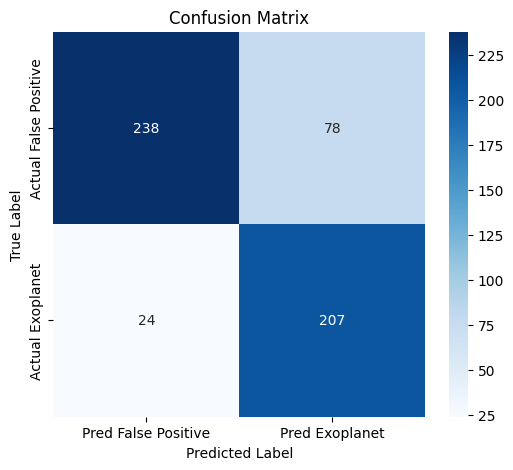

In [9]:
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['False Positive', 'Planet'])
cm = confusion_matrix(y_test, y_pred)

print(
    f"Model Accuracy: {acc * 100:.2f}%\n\n"
    f"Classification Report:\n"
    f"{class_report}"
)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred False Positive', 'Pred Exoplanet'], 
            yticklabels=['Actual False Positive', 'Actual Exoplanet'])
plt.title(f'Confusion Matrix')
plt.ylabel('True Label') #double check naming
plt.xlabel('Predicted Label') #double check naming

plt.savefig('../images/Confusion_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## Bonus Graphs
This is the code used to generate some of the graphs located in `README.md` . They also provide some useful insight and opportunities for further analysis.

#### Average Light Curves
This plots the average light curves for the identified planets and false positives. This helps shed some light on the differences the model noticed. The false positives tend to have a much steeper and larger dip than the planets.

#### Feature Importance by Phase Bin
This graph helps illustrate what points of the lightcurve were seen as more important by the training model. This shows that the points closer to the center had a larger influence on determining the classification of the lightcurve. This makes sense as it is where the transit actually occurs.

#### Misidentified Curves
These curves were misidentified by the model as being a planet, but in reality were false positives. Some have almost straight lines with lots of noise, others show shallow dips.

#### ROC Curve
This graph shows the tradeoff between the false positive rate and the true positive rate. Depending on the probability threshold of the model, it will locate more planets at the expense of increasing its false positive rate, or it can limit the amount of false positives, but that comes at the expense of locating confirmed targets.

The right-hand axis indicates the probability threshold required to achieve that performance point. Tick labels are color-coded to match the corresponding points on the ROC curve.

The area under the curve (AUC) gives an overall grade for how good a model is. It is a better benchmark than model accuracy, which changes based on the threshold values. 

#### Distribution of KOI Periods
This plots the periods of every object in the KOI catalog on a log scale.

#### Threshold Confusion Matrices
These graphs illustrate how the model behavior changes depending on the threshold value set during training. The $3$ threshold values chosen here represent key points on the ROC graph.

#### Sample Lightcurves
This shows $10$ sample lightcurves from the filtered data, $5$ confirmed planets, and $5$ false positives.

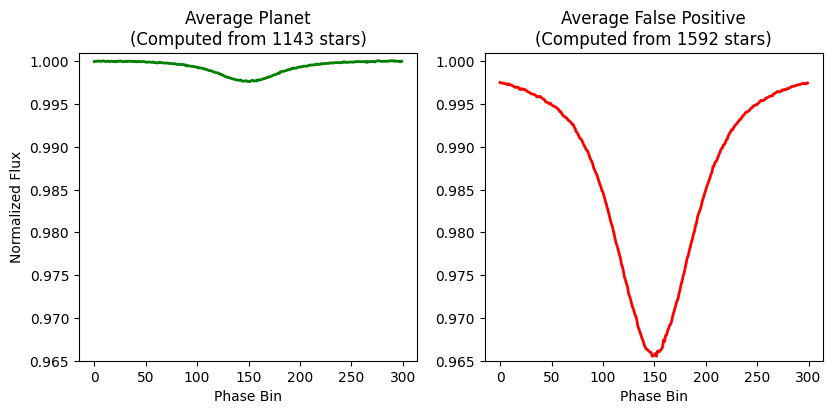

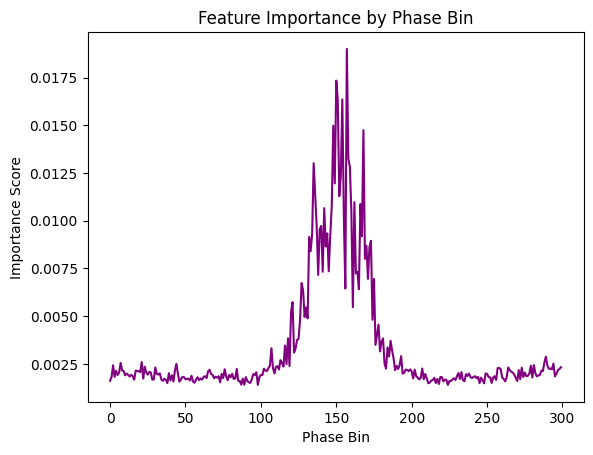

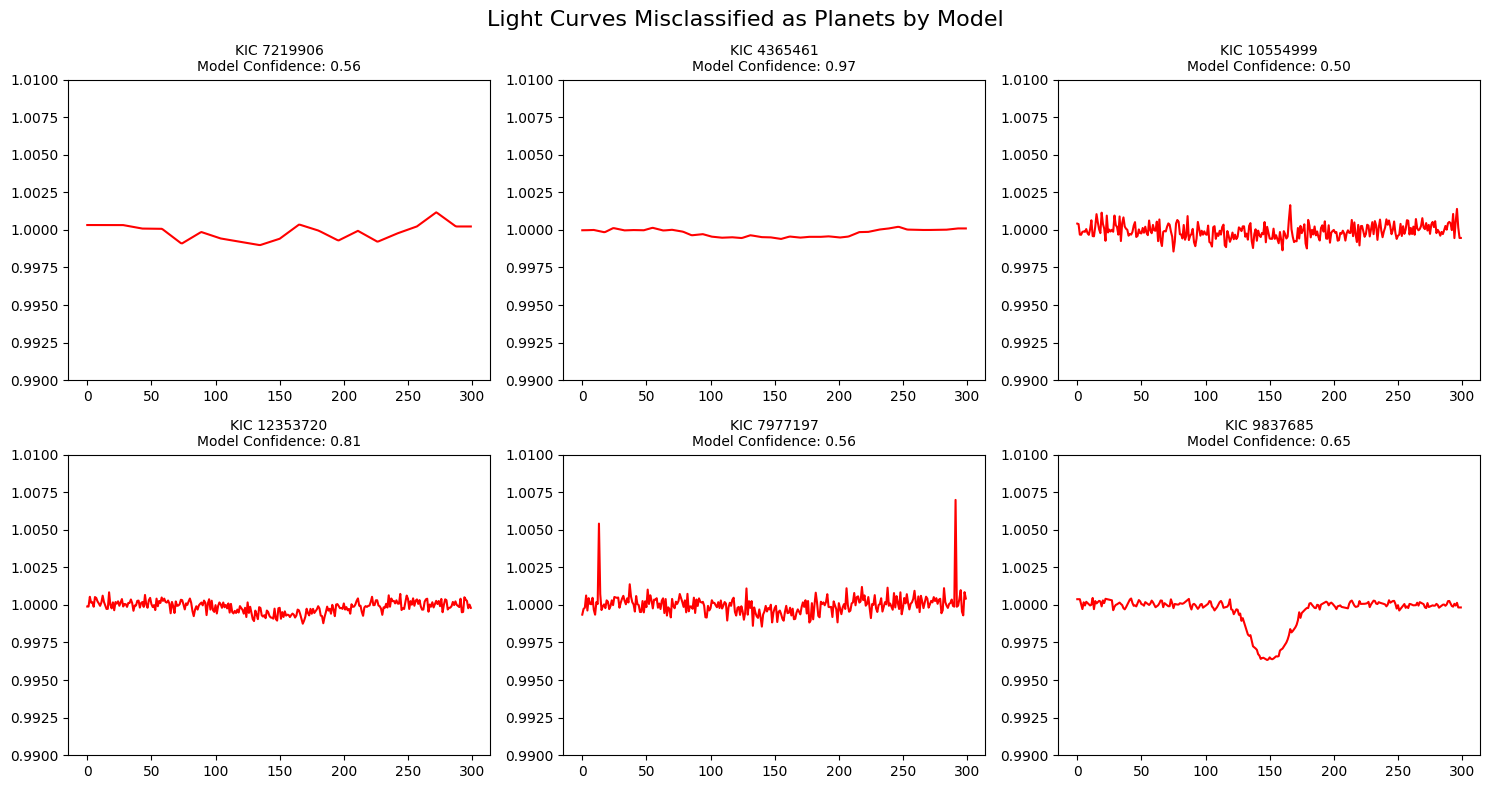

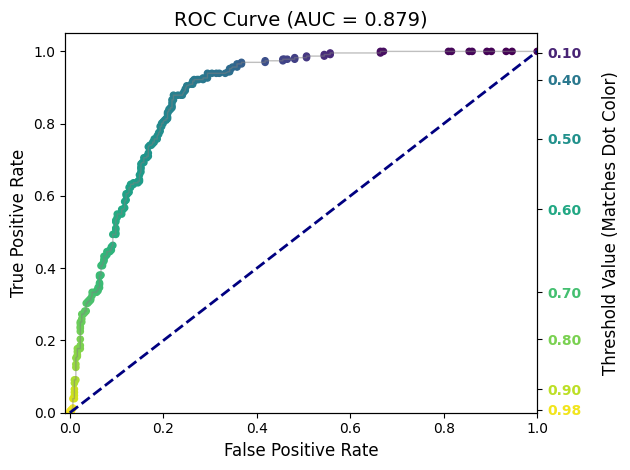

ROC Area Under Curve (AUC): 0.8791
Total Test Samples: 547
Total 'Impostors' (FP -> Planet): 78
Performance at specific thresholds:
Threshold  | True Positive Rate (Recall) | False Positive Rate 
0.000      | 1.000                     | 1.000               
0.041      | 0.996                     | 0.665               
0.116      | 0.996                     | 0.557               
0.159      | 0.987                     | 0.506               
0.204      | 0.974                     | 0.456               
0.245      | 0.970                     | 0.418               
0.326      | 0.965                     | 0.358               
0.370      | 0.939                     | 0.332               
0.421      | 0.896                     | 0.247               
0.472      | 0.805                     | 0.199               
0.526      | 0.706                     | 0.158               
0.578      | 0.602                     | 0.120               
0.633      | 0.463                     | 0.092              

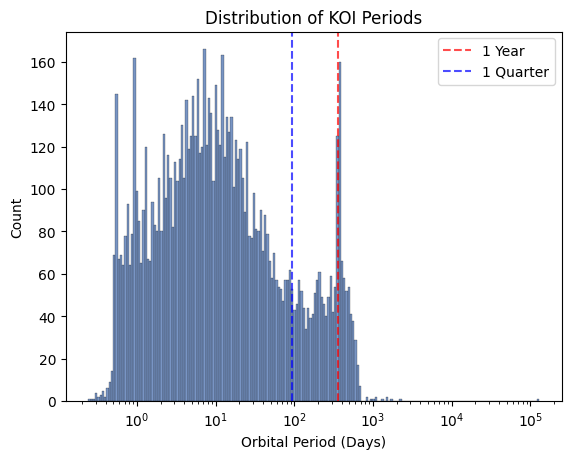

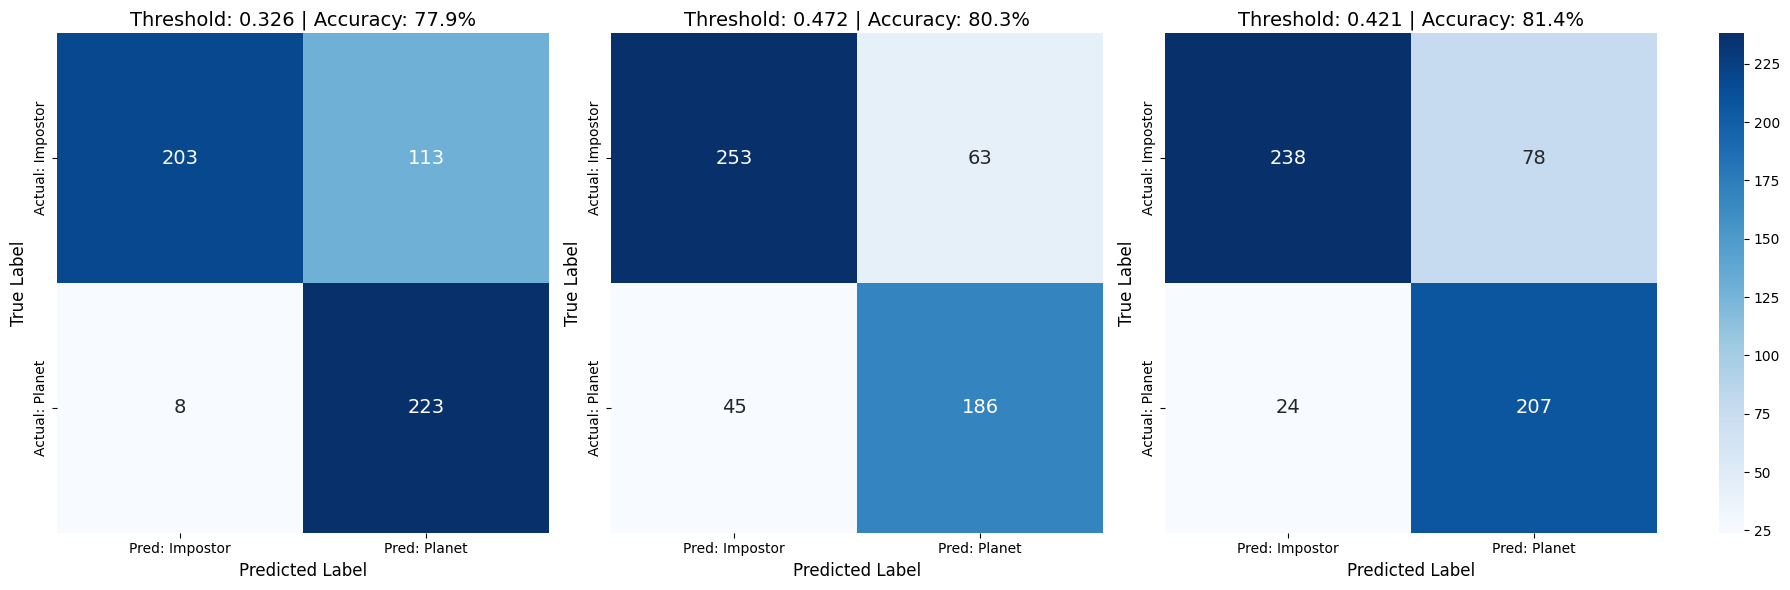

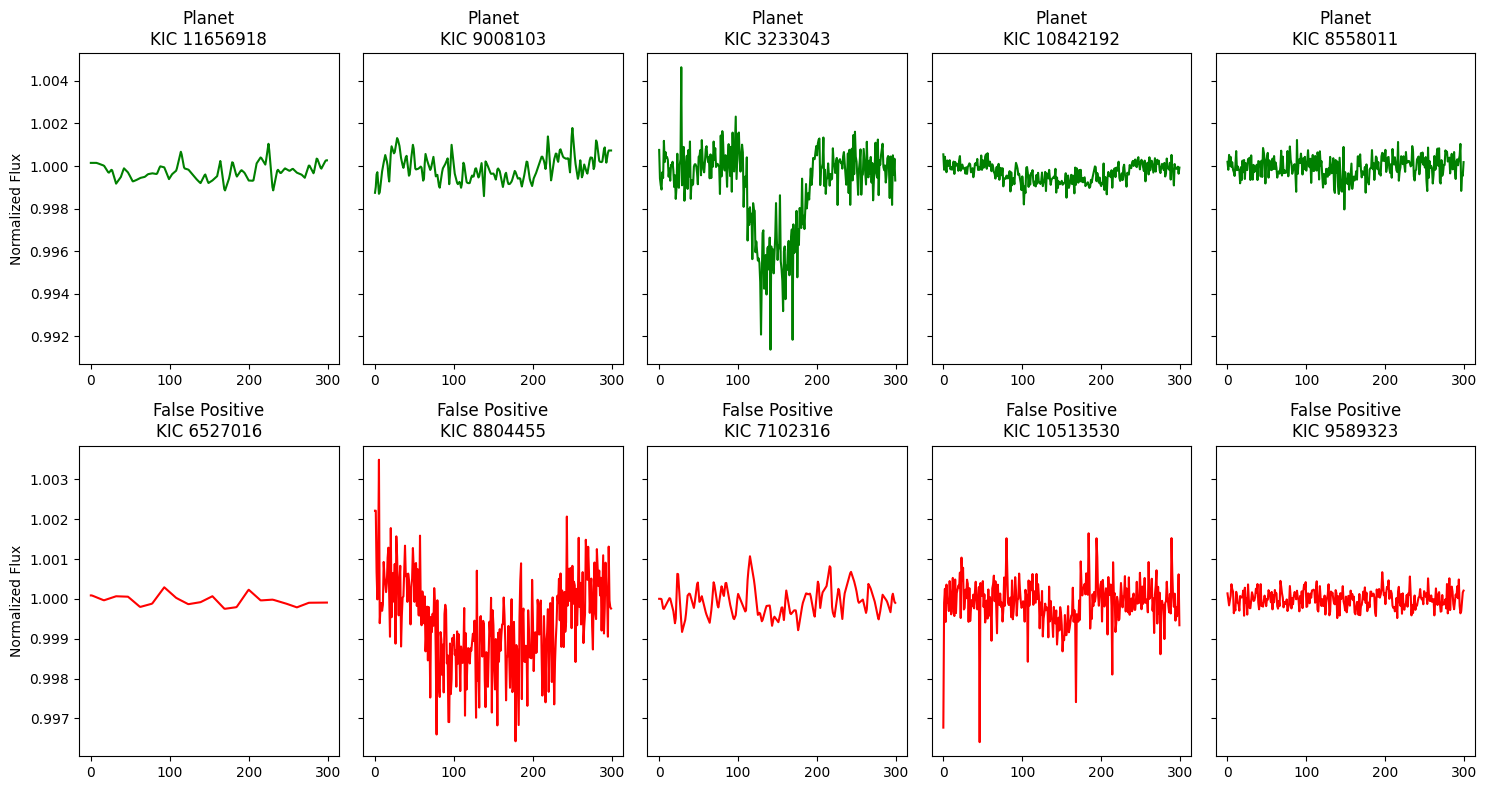

In [40]:
###### Average Plots ######

#calc mean light curves for found planets and false positives
mean_planet = np.mean(X_filtered[y_filtered == 1], axis=0)
mean_fp = np.mean(X_filtered[y_filtered == 0], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(9.6, 4)
                              )


ax1.plot(mean_planet, color='green', linewidth=2)
ax1.set_title(f"Average Planet\n(Computed from {np.sum(y_filtered==1)} stars)")
ax1.set_xlabel("Phase Bin")
ax1.set_ylabel("Normalized Flux")
ax1.set_ylim(0.965, 1.001)

ax2.plot(mean_fp, color='red', linewidth=2)
ax2.set_title(f"Average False Positive\n(Computed from {np.sum(y_filtered==0)} stars)")
ax2.set_xlabel("Phase Bin")
ax2.set_ylim(0.965, 1.001)

plt.savefig('../images/Average_Lightcurves.png', dpi=300, bbox_inches='tight')
plt.show()



###### Importance ######
importances = clf.feature_importances_

plt.figure()
plt.plot(importances, color='purple')
plt.title("Feature Importance by Phase Bin")
plt.xlabel("Phase Bin")
plt.ylabel("Importance Score")
#plt.grid(alpha=0.3)
plt.savefig('../images/Importance_Graph.png', dpi=300, bbox_inches='tight')
plt.show()




###### Misidentified ######
false_alarms = np.where((y_test == 0) & (y_pred == 1))[0]


num_to_plot = min(6, len(false_alarms)) #show 6 plots, change number here if wanted
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Light Curves Misclassified as Planets by Model", fontsize=16)


axes_flat = axes.flatten() #easier to index over in for loop
    
for i in range(num_to_plot):
    idx = false_alarms[i]
    ax = axes_flat[i]
        
        
    ax.plot(X_test[idx], color='red', linewidth=1.5)
    ax.set_title(f"KIC {ids[idx]}\nModel Confidence: {clf.predict_proba([X_test[idx]])[0][1]:.2f}", fontsize=10)
    ax.set_ylim(0.99, 1.01) #double check this shows every graph

        
plt.tight_layout()
plt.savefig('../images/Misidentified_Lightcurves.png', dpi=300, bbox_inches='tight')
plt.show()



###### ROC ######
y_probs = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
thresholds[0] = min(thresholds[0], 1.0)

#needed for right hand side labels
my_cmap = plt.get_cmap('viridis') 
norm = mcolors.Normalize(vmin=0, vmax=1) # Normalizes 0-1 range

#setup plot
fig, ax1 = plt.subplots()
scatter = ax1.scatter(fpr, tpr, c=thresholds, cmap='viridis', s=20, vmin=0, vmax=1, label='Threshold Positions')
ax1.plot(fpr, tpr, color='gray', lw=1, alpha=0.5, label=f'ROC curve (AUC = {roc_auc:.3f})')

ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
ax1.set_xlim([-0.01, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title(f'ROC Curve (AUC = {roc_auc:.3f})', fontsize=14)

#right axis
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
target_thresholds = [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98]

#to color tick labels
tick_locs = []
tick_labels = []
tick_colors = []

for i in target_thresholds:
    idx = np.argmin(np.abs(thresholds - i))
    tick_locs.append(tpr[idx])     
    tick_labels.append(f"{i:.2f}")  
    tick_colors.append(my_cmap(norm(i))) 

ax2.set_yticks(tick_locs)
ax2.set_yticklabels(tick_labels, fontweight='bold')
ax2.set_ylabel('Threshold Value (Matches Dot Color)', fontsize=12, labelpad=15)
for label, color in zip(ax2.get_yticklabels(), tick_colors):
    label.set_color(color)

plt.tight_layout()
plt.savefig('../images/ROC_Graph.png', dpi=300, bbox_inches='tight')
plt.show()

#graph above, text output below
print(f"ROC Area Under Curve (AUC): {roc_auc:.4f}")
print(f"Total Test Samples: {len(y_test)}")
print(f"Total 'Impostors' (FP -> Planet): {len(false_alarms)}")
print("Performance at specific thresholds:")

search_thresholds = np.linspace(0, 1, 20)# [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2 0.1]
print(f"{'Threshold':<10} | {'True Positive Rate (Recall)':<25} | {'False Positive Rate':<20}") #change for columns widths


for t in search_thresholds:
    
    idx = np.argmin(np.abs(thresholds - t))
    print(f"{thresholds[idx]:<10.3f} | {tpr[idx]:<25.3f} | {fpr[idx]:<20.3f}")



    
#### Period of entire KOI database lightcurves
plt.figure()
sns.histplot(data=koi_table, x='koi_period', bins=200, log_scale=True, kde=False, color='#4C72B0')
#log scale

plt.title('Distribution of KOI Periods')
plt.xlabel('Orbital Period (Days)')
plt.ylabel('Count')

#horizontal lines for context
plt.axvline(x=365.25, color='red', linestyle='--', alpha=0.7, label='1 Year')
plt.axvline(x=93, color='blue', linestyle='--', alpha=0.7, label='1 Quarter')
#plt.axvline(x=30, color='orange', linestyle='--', alpha=0.7, label='Cutoff')
plt.legend()
plt.savefig('../images/KOI_Periods.png', dpi=300, bbox_inches='tight')
plt.show()



##### comparing threshold values obtained from ROC #####
fig, all_axes = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]})
#3 axes for plots, last empty one just for cbar
plot_axes = all_axes[:3]
cbar_ax = all_axes[3]
thresholds_to_test = [0.326, 0.472, 0.421]

for i, t in enumerate(thresholds_to_test):
    ax = plot_axes[i]
    
    y_pred = (y_probs >= t).astype(int)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    is_last = (i == 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=is_last, cbar_ax=cbar_ax if is_last else None, 
                annot_kws={"size": 14}, xticklabels=['Pred: Impostor', 'Pred: Planet'], 
                yticklabels=['Actual: Impostor', 'Actual: Planet'])
    
    ax.set_title(f"Threshold: {t} | Accuracy: {acc:.1%}", fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('../images/Threshold_Confusion_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()


######## visualizing random lightcurves from data
def plot_examples(X_data, y_data, ids_data, num_examples=3):
    planet_indices = np.where(y_data == 1)[0]
    fp_indices = np.where(y_data == 0)[0]

    # random samples
    p_samples = np.random.choice(planet_indices, num_examples, replace=False)
    fp_samples = np.random.choice(fp_indices, num_examples, replace=False)

    fig, axes = plt.subplots(2, num_examples, figsize=(15, 8), sharey='row')
    

    for i, idx in enumerate(p_samples):
        ax = axes[0, i]
        ax.plot(X_data[idx], color='green')
        ax.set_title(f"Planet\nKIC {ids_data[idx]}")
        if i == 0: ax.set_ylabel("Normalized Flux")

    for i, idx in enumerate(fp_samples):
        ax = axes[1, i]
        ax.plot(X_data[idx], color='red')
        ax.set_title(f"False Positive\nKIC {ids_data[idx]}")
        #ax.set_xlabel("Phase Bin")
        if i == 0: ax.set_ylabel("Normalized Flux")

    plt.tight_layout()
    plt.savefig('../images/Random_Lightcurve_Samples.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_examples(X_filtered, y_filtered, allowed_ids, num_examples=5)